Calculate velocities and advection in moisture space

In [1]:
from importlib import reload
import numpy as np
import os
import random
import pickle
import multiprocessing
import functools
import seaborn
import logging
import typhon
import cmocean
from pylab import cm
from os.path import join
from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d, interp2d
from scipy.signal import detrend
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as ml_colors
import processing_tools as ptools
import analysis_tools as atools
from moisture_space import utils, plots
from moisture_space import moisture_space
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)

In [2]:
models = ['ICON', 'NICAM', 'SAM', 'IFS', 'UM', 'GEOS', 'ARPEGE']
runs = {
    'ICON': ['2.5km'],
    'NICAM': ['3.5km'],
    'SAM': ['4.0km'],
    'UM': ['5.0km'],
    'FV3': ['3.25km'],
    'GEOS': ['3.0km'],
    'IFS': ['4.0km'],
    'MPAS': ['3.75km'],
    'ARPEGE': ['2.5km'],
    'ERA5': ['31.0km']
}
exps = []
for m in models:
    for run in runs[m]:
        exps.append(m+'-'+run)
        
time_period = ['0810', '0908']
variables_3D = ['TEMP', 'PRES', 'QV', 'RH', 'W']
variables_2D = ['IWV']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}/random_samples/'
filenames = '{}-{}_{}_sample_{}_{}-{}{}.nc'
num_profiles = int(1 * 1e7)
perc_values = np.arange(2., 100.5, 2.0)
reduced_percs_50 = np.arange(1.5, 100.5, 2)
reduced_percs_25 = np.arange(2.5, 100.5, 4)
num_percs = len(perc_values)
bin_size = 1. / num_percs
iwv_bin_bnds = np.arange(0, 101, 1)
bin_values = iwv_bin_bnds[:-1] + 0.5 * np.diff(iwv_bin_bnds)
bins = range(len(iwv_bin_bnds) - 1) 
exp = 0
h = np.arange(100, 17600, 200) # height vector to interpolate all models on
height = {}
num_levels = {}
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        filename = filenames.format(m, run, variables_3D[0], num_profiles, time_period[0], time_period[1], '')
        if run == '2.5km_winter':
            filename = filenames.format(m, run, variables_3D[0], num_profiles, '0120', '0202')
        if m == 'ERA5':
            filename = f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/ERA5/2016/random_samples/{filename}'
        else:
            filename = join(datapath.format(m), filename)
        #xarr = xr.open_dataset(filename)
        with(Dataset(filename)) as ds:
            height[key] = ds.variables['height'][:].filled(np.nan)
        num_levels[key] = len(height[key])
plt.style.use(typhon.plots.styles.get('typhon'))        

# Read data

In [3]:
reload(moisture_space)
perc = {}
binned = {}
ms_perc = {}
ms_bins = {}
percentiles = {}
for m in models:
    for run in runs[m]:
        exp = m+'-'+run
        print(exp)
        if m == 'ERA5':
            p = f'{m}/2016'
        else:
            p = m
        ms_perc[exp] = {}
        ms_bins[exp] = {}     
                    
        path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_50_perc_means_{num_profiles}_1exp.pkl'
             
        with open(join(datapath.format(p), path_perc), 'rb' ) as infile:
            perc = pickle.load(infile)

        for var in variables_3D:
            stats_perc = moisture_space.ProfileStats.from_dict(perc, var)
            ms_perc[exp][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, height[exp]).interpolate(h, kind='linear')
        for var in variables_2D:
            stats_perc = moisture_space.ProfileStats.from_dict(perc, var)
            ms_perc[exp][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, None)   

ICON-2.5km
NICAM-3.5km
SAM-4.0km
IFS-4.0km
UM-5.0km
GEOS-3.0km
ARPEGE-2.5km


# Calculate effective stream function

Relation between streamfunction and velocity in x and z-direction (u and w, respectively):

\begin{equation*}
u = \frac{1}{\rho} \frac{\partial \Psi}{\partial z}
\end{equation*}
\begin{equation*}
w = - \frac{1}{\rho} \frac{\partial \Psi}{\partial x}
\end{equation*}

Unit of the streamfunction: kg m-2 s-1

In [4]:
for exp in exps:
    # density (of moist air)
    density = utils.calc_density_moist_air(
        ms_perc[exp]['PRES'].mean,
        ms_perc[exp]['TEMP'].mean,
        ms_perc[exp]['QV'].mean
    )
        
    ms_perc[exp]['RHO'] = moisture_space.PercMoistureSpace.from_mean(density, 'RHO', exp, perc_values, h)

In [5]:
h_half = h[:-1] + 0.5 * np.diff(h)
# streamfunction is defined on edges of the IWV bins. Define new x-values for the streamfunction:
bins_streamfunction = perc_values[:-1] + 0.5 * np.diff(perc_values)
bins_streamfunction = np.hstack((perc_values[0] - 0.5 * np.diff(perc_values)[0], bins_streamfunction, perc_values[-1] + 0.5 * np.diff(perc_values)[-1]))
streamfunction = {}
for exp in exps:
    streamfunction[exp] = {}

    streamfunction[exp] = np.zeros((num_percs+1, len(h)))
    density = ms_perc[exp]['RHO'].mean
    density_for_x_velocity = np.vstack((density[0], density))

    # calculate streamfunction
    # assumpition: circulation/mass budget is closed on the dry end of moisture space
    for i in range(1, num_percs+1):
        streamfunction[exp][i] = streamfunction[exp][i-1] + density[i-1] * ms_perc[exp]['W'].mean[i-1] * bin_size
#        # assumption: circulation/mass budget is closed on the moist end of moisture space
#         for i in range(num_percs, 0, -1):
#             streamfunction[exp][b][i-1] = streamfunction[exp][b][i] + density[i] * ms_perc[exp][b]['W'].mean[i-1] * bin_size

    # horizontal velocity: vertical derivative of streamfunction, devided by density
    x_velocity = -np.diff(streamfunction[exp], axis=1) / np.diff(h) / density_for_x_velocity[:, 1:]
    # vertical velocity (check): horizontal derivative of streamfunction, devided by density
    z_velocity = np.diff(streamfunction[exp], axis=0) / density / bin_size

    # interpolate horizontal velocities to the same grid as vertical velocities and q field
    x_velocity_interp_func = interp2d(h_half, bins_streamfunction, x_velocity, kind='cubic')
    x_velocity_interp = x_velocity_interp_func(h, perc_values)
    # Create PercMoistureSpace objects
    ms_perc[exp]['VX'] = moisture_space.PercMoistureSpace.from_mean(x_velocity_interp, 'VX', exp, perc_values, h)
    ms_perc[exp]['VZ'] = moisture_space.PercMoistureSpace.from_mean(z_velocity, 'VZ', exp, perc_values, h)

In [6]:
reload(moisture_space)
calculated_variables = ['VX', 'VZ']
ms_perc_series = {}
ms_a = {} # dictionary containing model anomalies with respect to multi-model mean
ms_a_series = {} # dictionary containing series of model anomalies

for var in variables_3D+calculated_variables:
    print(var)
    perc_space_list = [ms_perc[exp][var] for exp in exps]
    ms_perc_series[var] = moisture_space.MoistureSpaceSeries(perc_space_list)


for var in variables_3D+calculated_variables:
    ms_a[var] = {}
    for exp in exps:
        ms_a[var][exp] = moisture_space.PercMoistureSpace.from_mean(
            ms_perc[exp][var].mean - ms_perc_series[var].mean,
            var, exp, perc_values, h)

for var in variables_3D+calculated_variables:
    perc_space_list = [ms_a[var][exp] for exp in exps]
    ms_a_series[var] = moisture_space.MoistureSpaceSeries(perc_space_list)
        

TEMP
PRES
QV
RH
W
VX
VZ


# Calculate tendencies

In [8]:
reload(moisture_space)
transport_terms_q = [
    'v_grad_q_h', # advection of q with circulation in horizontal direction
    'v_grad_q_v', # advection of q with circulation in vertical direction
    'vm_grad_qm_h', # advection of mean q with mean circulation, in horizontal direction
    'vm_grad_qm_v', # advection of mean q with mean circulation, in vertical direction
    'vm_grad_qa_h', # advection of anomalous q with mean circulation, in horizontal direction
    'vm_grad_qa_v', # advection of anomalous q with mean circulation, in vertical direction
    'va_grad_qm_h', # advection of mean q with anomalous circulation, in horizontal direction
    'va_grad_qm_v', # advection of mean q with anomalous circulation, in vertical direction
    'va_grad_qa_h', # advection of anomalous q with anomalous circulation, in horizontal direction
    'va_grad_qa_v', # advection of anomalous q with anomalous circulation, in vertical direction
]
    
t_q = {k: {} for k in transport_terms_q}
                      

t_q['vm_grad_qm_h'] =  moisture_space.PercMoistureSpace.from_mean(
    -ms_perc_series['VX'].mean * np.gradient(ms_perc_series['QV'].mean, bin_size, axis=0),
    'vm_grad_qm_h', exp, perc_values, h
)

t_q['vm_grad_qm_v'] = moisture_space.PercMoistureSpace.from_mean(
    -ms_perc_series['W'].mean * np.gradient(ms_perc_series['QV'].mean, h, axis=1),
    'vm_grad_qm_v', exp, perc_values, h
) 

t_q['vm_grad_qa_h'] = {}
t_q['vm_grad_qa_v'] = {}
t_q['va_grad_qm_h'] = {}
t_q['va_grad_qm_v'] = {}
t_q['va_grad_qa_h'] = {}
t_q['va_grad_qa_v'] = {}
t_q['v_grad_q_h'] = {}
t_q['v_grad_q_v'] = {}


for exp in exps:
    # Tendencies in specific humidity

    t_q['v_grad_q_h'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -ms_perc[exp]['VX'].mean * np.gradient(ms_perc[exp]['QV'].mean, bin_size, axis=0),
        'v_grad_q_h', exp, perc_values, h
    ) 

    t_q['v_grad_q_v'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -ms_perc[exp]['W'].mean * np.gradient(ms_perc[exp]['QV'].mean, h, axis=1),
        'v_grad_q_v', exp, perc_values, h
    )


    t_q['vm_grad_qa_h'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -ms_perc_series['VX'].mean * np.gradient(ms_perc[exp]['QV'].mean - ms_perc_series['QV'].mean, bin_size, axis=0),
        'vm_grad_q_h', exp, perc_values, h
    )  

    t_q['vm_grad_qa_v'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -ms_perc_series['W'].mean * np.gradient(ms_perc[exp]['QV'].mean - ms_perc_series['QV'].mean, h, axis=1),
        'vm_grad_qa_v', exp, perc_values, h
    )   

    t_q['va_grad_qm_h'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -(ms_perc[exp]['VX'].mean - ms_perc_series['VX'].mean) * np.gradient(ms_perc_series['QV'].mean, bin_size, axis=0),
        'va_grad_qm_h', exp, perc_values, h
    )     

    t_q['va_grad_qm_v'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -(ms_perc[exp]['W'].mean - ms_perc_series['W'].mean) * np.gradient(ms_perc_series['QV'].mean, h, axis=1),
        'va_grad_qm_v', exp, perc_values, h
    )     

    t_q['va_grad_qa_h'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -(ms_perc[exp]['VX'].mean - ms_perc_series['VX'].mean) * np.gradient(ms_perc[exp]['QV'].mean - ms_perc_series['QV'].mean, bin_size , axis=0),
        'va_grad_qa_h', exp, perc_values, h
    )     

    t_q['va_grad_qa_v'][exp] = moisture_space.PercMoistureSpace.from_mean(
        -(ms_perc[exp]['W'].mean - ms_perc_series['W'].mean) * np.gradient(ms_perc[exp]['QV'].mean - ms_perc_series['QV'].mean, h, axis=1),
        'va_grad_qa_v', exp, perc_values, h
    )
               
ts_q = {} # dictionary containing series of spec. hum. tendencies of all models
ta_q = {} # dictionary containing anomalies of spec. hum. tendencies for each model
tas_q = {} # dictionary containing series of spec. hum. anomalies

for term in transport_terms_q:
    if term not in ['vm_grad_qm_h', 'vm_grad_qm_v']:
        ts_q[term] = {}
        ta_q[term] = {}
        tas_q[term] = {}
        
        space_list_q = [t_q[term][exp] for exp in exps]
        ts_q[term] = moisture_space.MoistureSpaceSeries(space_list_q)
        ta_q[term] = {}
        for exp in exps:
            ta_q[term][exp] = moisture_space.PercMoistureSpace.from_mean(
                t_q[term][exp].mean - ts_q[term].mean,
                term, exp, perc_values, h
            )
        space_list_qa = [ta_q[term][exp] for exp in exps]
        tas_q[term] = moisture_space.MoistureSpaceSeries(space_list_qa)       

# Anomalies in circulation

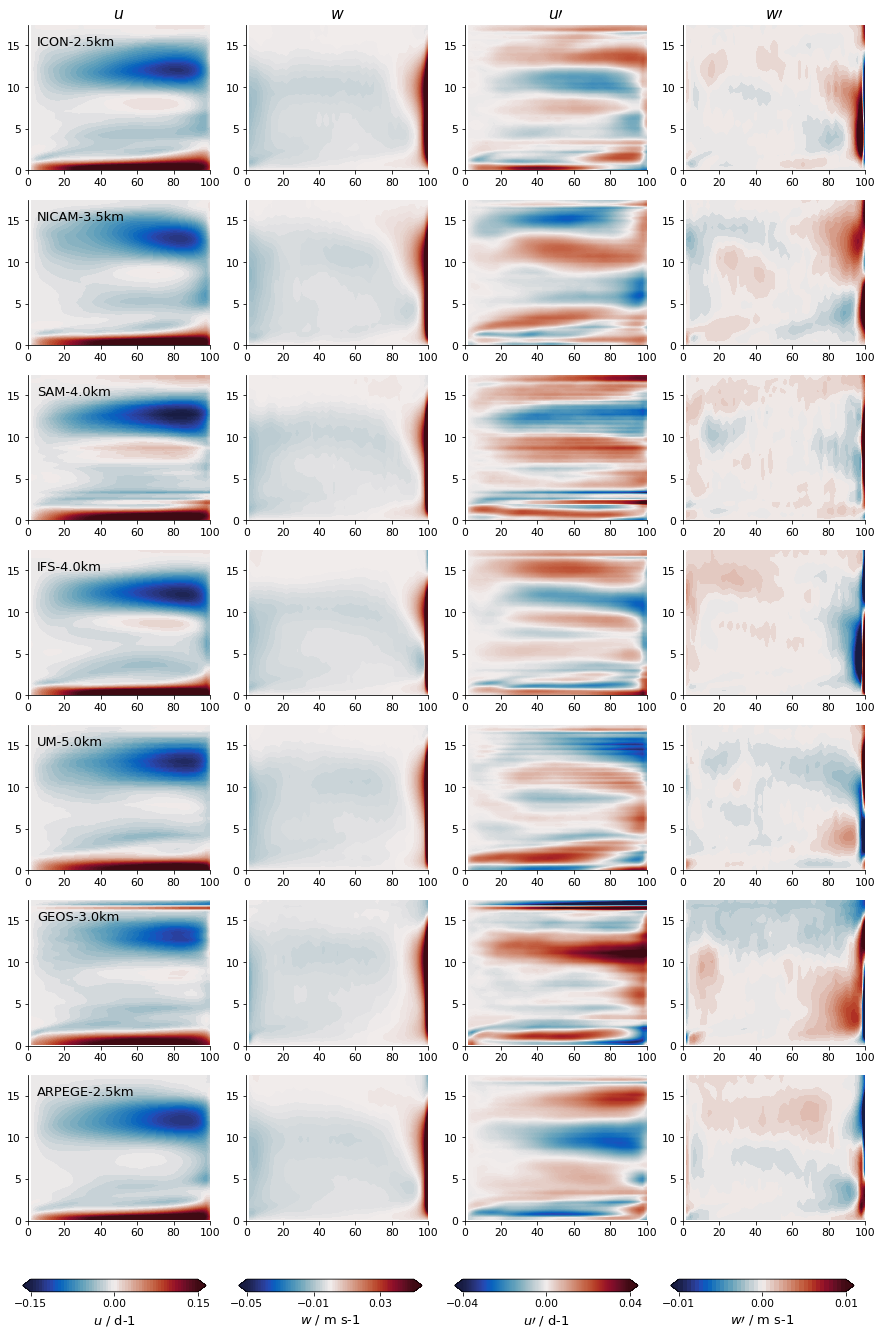

In [9]:

plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(len(exps), 4, figsize=(15, 22))
contours_u = np.arange(-0.15, 0.1501, 0.005)
contours_ua = np.arange(-0.04, 0.0401, 0.0005)
contours_w = np.arange(-0.05000, 0.05001, 0.001)
contours_wa = np.arange(-0.01000, 0.01001, 0.0005)
x_lims = [0, 100]
y_lims = [0, 17.5]
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    imu = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, ms_perc[exp]['VX'].mean.T * 60 * 60 * 24, contours_u,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_u[0], vmax=contours_u[-1])
    imw = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, ms_perc[exp]['W'].mean.T, contours_w,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_w[0], vmax=contours_w[-1])
    imua = plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, (ms_a['VX'][exp].mean.T) * 60 * 60 * 24, contours_ua,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_ua[0], vmax=contours_ua[-1])
    imwa = plots.moisture_space_contourf(fig, ax[i, 3], perc_values, h * 1e-3, (ms_a['W'][exp].mean.T), contours_wa,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_wa[0], vmax=contours_wa[-1])
    
    
ax[0, 0].set_title('$u$')
ax[0, 1].set_title('$w$')
ax[0, 2].set_title(r'$u \prime$')
ax[0, 3].set_title(r'$w \prime$')
cb_ax = fig.add_axes([0.12, 0.08, 0.17, 0.008])
fig.colorbar(imu, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.15, 0.151, 0.15), label='$u$ / d-1')
cb_ax = fig.add_axes([0.32, 0.08, 0.17, 0.008])
fig.colorbar(imw, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.05, 0.0501, 0.04), label='$w$ / m s-1')
cb_ax = fig.add_axes([0.52, 0.08, 0.17, 0.008])
fig.colorbar(imua, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.04, 0.0401, 0.04), label=r'$u \prime$ / d-1')
cb_ax = fig.add_axes([0.72, 0.08, 0.17, 0.008])
fig.colorbar(imwa, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.01, 0.011, 0.01), label=r'$w \prime$ / m s-1')

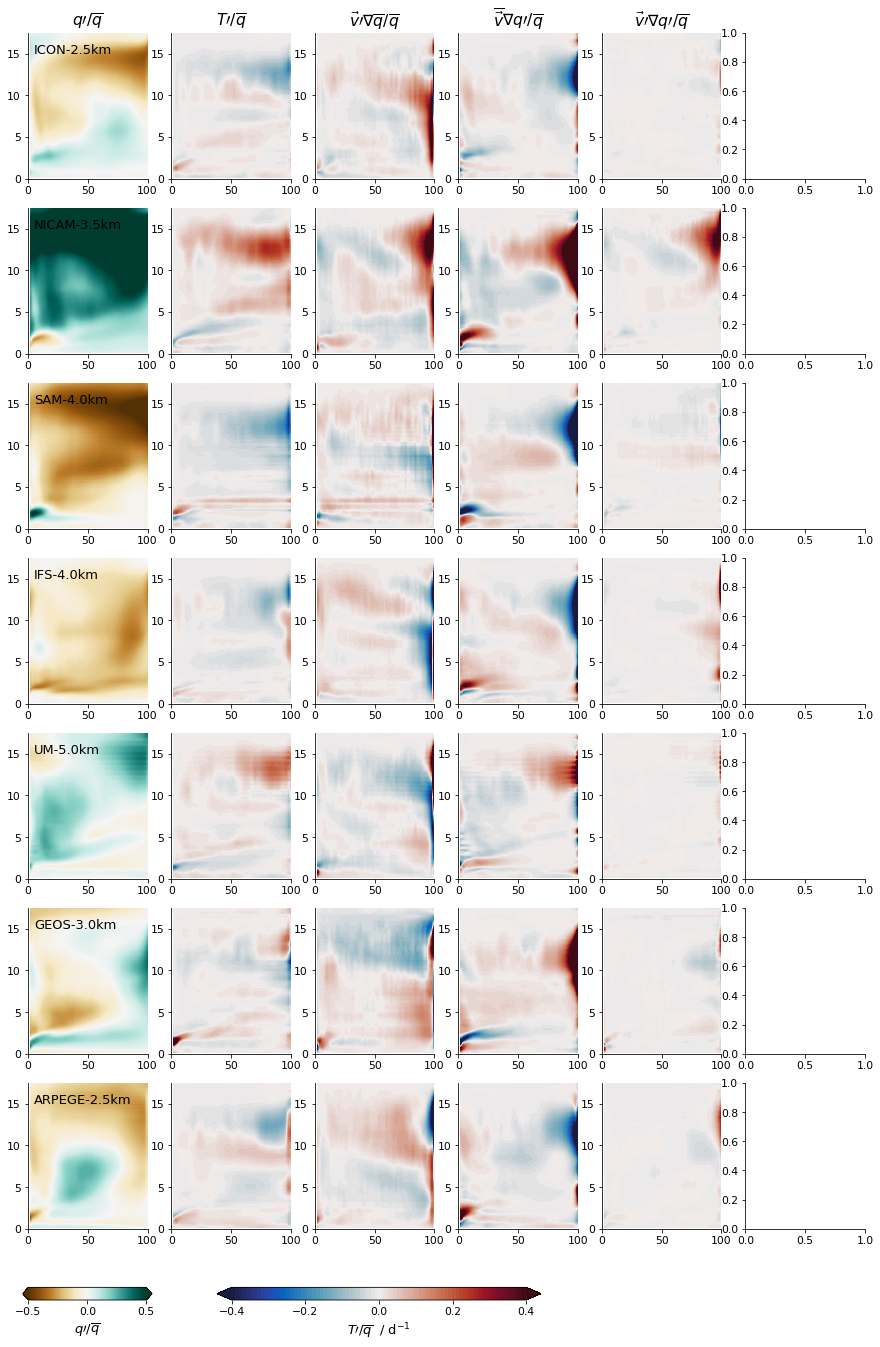

In [12]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(len(exps), 5, figsize=(15, 22))
contours = np.arange(-0.5, 0.501, 0.005)
contours_q = np.arange(-0.5, 0.501, 0.005)
contours_a = np.arange(-0.4, 0.401, 0.01)
x_lims = [0, 100]
y_lims = [0, 17.5]
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    imq = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, (ms_perc[exp]['QV'].mean.T - ms_perc_series['QV'].mean.T) / ms_perc_series['QV'].mean.T, contours_q,\
                              x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='BrBG', vmin=contours_q[0], vmax=contours_q[-1])
    ima = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, (t_q['va_grad_qm_h'][exp].mean.T + t_q['vm_grad_qa_h'][exp].mean.T + t_q['va_grad_qa_h'][exp].mean.T) / ms_perc_series['QV'].mean.T * 60 * 60 * 24, contours_a,\
                              x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_a[0], vmax=contours_a[-1])
    plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, (t_q['va_grad_qm_h'][exp].mean.T + t_q['va_grad_qm_v'][exp].mean.T) / ms_perc_series['QV'].mean.T * 60 * 60 * 24, contours_a,\
                              x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_a[0], vmax=contours_a[-1])
    plots.moisture_space_contourf(fig, ax[i, 3], perc_values, h * 1e-3, (t_q['vm_grad_qa_h'][exp].mean.T + t_q['vm_grad_qa_v'][exp].mean.T) / ms_perc_series['QV'].mean.T * 60 * 60 * 24, contours_a,\
                              x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_a[0], vmax=contours_a[-1])
    plots.moisture_space_contourf(fig, ax[i, 4], perc_values, h * 1e-3, (t_q['va_grad_qa_h'][exp].mean.T + t_q['va_grad_qa_v'][exp].mean.T) / ms_perc_series['QV'].mean.T * 60 * 60 * 24, contours_a,\
                              x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_a[0], vmax=contours_a[-1])    


ax[0, 0].set_title('$q \prime / \overline{q}$')
ax[0, 1].set_title(r'$T \prime / \overline{q} $')
ax[0, 2].set_title(r'$\vec{v} \prime \nabla{\overline{q}} / \overline{q}$')
ax[0, 3].set_title(r'$\overline{\vec{v}} \nabla{q \prime} / \overline{q}$')
ax[0, 4].set_title(r'$\vec{v} \prime \nabla{q} \prime / \overline{q}$')

cb_ax = fig.add_axes([0.12, 0.08, 0.12, 0.008])
fig.colorbar(imq, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.5, 0.501, 0.5), label='$q \prime / \overline{q}$')

cb_ax = fig.add_axes([0.3, 0.08, 0.3, 0.008])
fig.colorbar(ima, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.4, 0.401, 0.2), label=r'$T \prime / \overline{q}$  / d$^{-1}$')